In [4]:
import numpy as np
from numpy import matlib as matlab
from numpy.fft import fft
import math
from scipy.signal import lfilter as filter
import scipy.signal as signal
import matplotlib.pyplot as plt
from mpl_toolkits import mplot3d
import imageio

from google.colab import files
uploaded = files.upload()

Saving atores.jpeg to atores (1).jpeg
Saving teste_fig.png to teste_fig (1).png
Saving face.png to face (1).png
Saving paisagem.png to paisagem (1).png


In [0]:
def my_RLS(x, d, L = 2, lbda = 0.99, partida = [0 for n in range(0, 200)]): 
  #Obs: a inicialização da partida é uma gambiarra pra funcionar até 100 coeficientes... 

  nCoeffs = L
  partida = partida[0:L]
  delta = 100

  # Construindo a matriz X dos coeficientes de x(n) ... x(n-L+1): 
  X = matlab.repmat(x.transpose(), nCoeffs, 1)
  for i in np.arange(0, nCoeffs): 
    X[i][:] = np.roll(X[i][:], [0, i-nCoeffs+1])
  X = X[:, 0:np.size(X, 1)-nCoeffs+1]

  # O mesmo com d(n)
  d = d[nCoeffs-1:d.size]

  # Construindo a matriz P(0)

  P = delta*np.identity(nCoeffs)
  
  # Inicialização do filtro 
  w_RLS = np.zeros((nCoeffs,1))
  w_RLS[:, 0] = partida

  # Inicialização da matriz que armazenará a evolução dos valores de w_SD
  w_RLS_hist = np.zeros((nCoeffs,X[0].size))

  for i in range(0, X[0].size): 
    k = ((1/lbda)*np.dot(P, X[:, i]))/(1+(1/lbda)*np.dot(X[:, i], np.dot(P, X[:, i])))
    y_RLS = np.dot(w_RLS.transpose(), X[:, i])
    e = d[i] - y_RLS;
    w_RLS = w_RLS + e*k.reshape(nCoeffs, 1);
    w_RLS_hist[:, i] = w_RLS.reshape(nCoeffs,)
    P = (1/lbda)*P - (1/lbda)*np.dot(k.reshape(nCoeffs, 1), np.dot(X[:, i].reshape(1, nCoeffs),P))

  return w_RLS, w_RLS_hist

In [0]:
def my_LMS(x, d, L = 2, mu = 0.001, partida = [0 for n in range(0, 200)]): 
  #Obs: a inicialização da partida é uma gambiarra pra funcionar até 100 coeficientes... 

  nCoeffs = L
  partida = partida[0:L]

  # Construindo a matriz X dos coeficientes de x(n) ... x(n-L+1): 
  X = matlab.repmat(x.transpose(), nCoeffs, 1)
  for i in np.arange(0, nCoeffs): 
    X[i][:] = np.roll(X[i][:], [0, i-nCoeffs+1])
  X = X[:, 0:np.size(X, 1)-nCoeffs+1]

  # O mesmo com d(n)
  d = d[nCoeffs-1:d.size]
  
  # Inicialização do filtro 
  w_LMS = np.zeros((nCoeffs,1))
  w_LMS[:, 0] = partida

  # Inicialização da matriz que armazenará a evolução dos valores de w_SD
  w_LMS_hist = np.zeros((nCoeffs,X[0].size))

  for i in range(0, X[0].size): 
    y_LMS = np.dot(w_LMS.transpose(), X[:, i])
    e = d[i] - y_LMS;
    w_LMS = w_LMS + 2*mu*X[:, i].reshape(nCoeffs,1)*e;
    w_LMS_hist[:, i] = w_LMS.reshape(nCoeffs,)

  return w_LMS, w_LMS_hist

# Aqui começa o filtro pra bits

In [0]:
# Funções usadas no projeto

def my_bitstream(f):
    # Aceita um vetor f, que seria a imagem... e converte para bytes
    s = np.zeros(8*f.size)
    for i in range(0, f.size): 
        for j in range(0, 8): 
            s[8*i+j] = f[i]>>j & 1

    return s

def my_debitstream(s): 
    # Aceita um vetor s que seria o sinal e converte para um vetor f que seria a imagem
    tamanho = (int)(s.size/8)
    f = np.zeros(tamanho)
    for i in range(0, tamanho): 
        for j in range(0, 8): 
            f[i] = f[i]+s[8*i+j]*(2**j)
            
    return f.astype(int)

def decisor(s): 
  # Aplica um decisor no sinal s
  tamanho = s.size
  f = np.zeros(tamanho)
  for i in range(0, tamanho): 
      if s[i] > 0.5: 
        f[i] = 1
      else:
        f[i] = 0
  return f.astype(int)

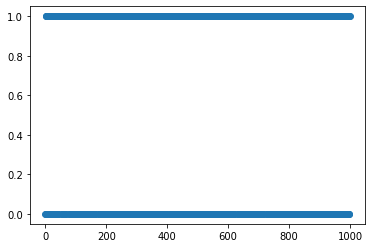

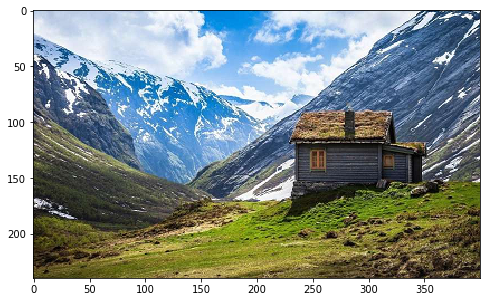

In [8]:
# Teste do codificador/decodificador

# Sinal de entrada
sf = imageio.imread(uploaded['paisagem.png'])
formato_sf = sf.shape

# Reshape e envio do sinal
teste = sf.reshape(sf.size,) # Transforma a matriz da imagem em um vetor de dimensão unitária
sinal = my_bitstream(teste)  # Converte o vetor em um vetor de bits

plt.plot(sinal[0:1000], 'o')
plt.show()

# Recepção do sinal e decodificação
recebido = decisor(sinal)
pos_decisor = my_debitstream(recebido)
imagem_pos_decisor = pos_decisor.reshape(formato_sf)

# Imagem recebida do outro lado
plt.figure(figsize = [8, 5])
plt.imshow(imagem_pos_decisor)
plt.show()



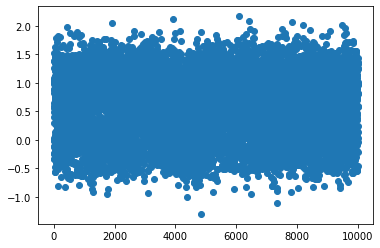

In [9]:
# Cálculo do Ruído
potencia = 0.1
r = np.random.randn(8*sf.size)*np.sqrt(potencia)
plt.plot((sinal+r)[0:10000], 'o')
plt.show()

In [10]:
# Aplicando o sinal com ruído no canal e plotando a imagem após o decisor
recebido = decisor(sinal+r)
pos_decisor = my_debitstream(recebido)
imagem_pos_decisor = pos_decisor.reshape(formato_sf)

# Obtendo os coeficientes do RLS para identificar o sistema

d = teste.reshape(teste.size) # Sinal de referência, vetor contendo a imagem de referência
x = pos_decisor.reshape(pos_decisor.size) # Sinal recebido, vetor contendo a imagem de referência com ruído

n_coeffs = [2, 3, 5, 10, 25, 50, 100, 200]
num = [[0] for i in range(0, len(n_coeffs))]

for j in range(0, len(n_coeffs)): 
  w, w_hist = my_RLS(x, d, n_coeffs[j])
  num[j] = np.array([w[i][0] for i in range(0, w.size)])

# Print dos filtros obtidos
print(num)

[array([0.56472955, 0.25967896]), array([0.49819461, 0.17127553, 0.18221381]), array([0.41680536, 0.12873828, 0.10867418, 0.20654784, 0.01163324]), array([ 0.39797165,  0.10589574,  0.12443508,  0.18264697, -0.0016196 ,
        0.02469135,  0.05421911, -0.03283046, -0.06623724,  0.09036779]), array([ 0.38980182,  0.10837846,  0.13154737,  0.16672091, -0.01055343,
        0.02619099,  0.03071074, -0.03928542, -0.09208708,  0.04894978,
       -0.02534536,  0.02752887,  0.06973385,  0.00898803,  0.00659863,
       -0.02342111, -0.02187074,  0.04147418,  0.05228885,  0.00110491,
       -0.01343988,  0.03724216, -0.01465164, -0.04122011,  0.0315551 ]), array([ 0.36829605,  0.11381668,  0.13239912,  0.14649889, -0.00490771,
        0.04291063,  0.02996235, -0.04830359, -0.07902434,  0.05005248,
       -0.03615658,  0.04191695,  0.06733632, -0.0034686 ,  0.00717055,
       -0.03630857, -0.00386215,  0.03848258,  0.05140593,  0.01455097,
       -0.01177106,  0.04520968, -0.01101374, -0.0297323

In [11]:
y = [filter(num[i], [1], x) for i in range(0, len(n_coeffs))]

plt.figure(figsize = [20, 35])
plt.subplot((int)(len(n_coeffs)/2+2), 2, 1)
plt.imshow(sf)
plt.xlabel("Imagem original")

plt.subplot((int)(len(n_coeffs)/2+2), 2, 2)
plt.imshow(imagem_pos_decisor)
plt.xlabel("Imagem com ruído")

for i in range(0, len(n_coeffs)): 
  plt.subplot((int)(len(n_coeffs)/2+2), 2, i+3)
  plt.imshow(y[i].reshape(formato_sf).astype(int))
  plt.xlabel("Filtro com "+str(n_coeffs[i])+" coeficientes")

plt.show()

Output hidden; open in https://colab.research.google.com to view.

In [12]:
# Tirar a prova real do equalizador: aplicá-lo em uma outra imagem e verificar os resultados...

# Lendo a imagem
prova = imageio.imread(uploaded['atores.jpeg'])

# Aplicando ruído no sinal da figura de prova
r_prova = np.random.randn(8*prova.size)*np.sqrt(potencia) # Cálculo do ruído
entrada_prova = my_bitstream(prova.reshape(prova.size,)) # Sinal de entrada sem ruído transformato em bits
saida_prova = decisor(entrada_prova + r_prova)
imagem_saida_prova = my_debitstream(saida_prova)

# Aplicando o sinal após o decisor no filtro
#y = filter(num[4], 1, imagem_saida_prova)
y = [filter(num[i], [1], imagem_saida_prova) for i in range(0, len(n_coeffs))]

plt.figure(figsize = [20, 35])
plt.subplot((int)(len(n_coeffs)/2+2), 2, 1)
plt.imshow(prova)
plt.xlabel("Imagem original")

plt.subplot((int)(len(n_coeffs)/2+2), 2, 2)
plt.imshow(imagem_saida_prova.reshape(prova.shape).astype(int))
plt.xlabel("Imagem com ruído")

for i in range(0, len(n_coeffs)): 
  plt.subplot((int)(len(n_coeffs)/2+2), 2, i+3)
  plt.imshow(y[i].reshape(prova.shape).astype(int))
  plt.xlabel("Filtro com "+str(n_coeffs[i])+" coeficientes")

plt.show()

Output hidden; open in https://colab.research.google.com to view.

In [13]:
# Tirar a prova real do equalizador: aplicá-lo em uma outra imagem e verificar os resultados...

# Lendo a imagem
prova = imageio.imread(uploaded['teste_fig.png'])

# Aplicando ruído no sinal da figura de prova
r_prova = np.random.randn(8*prova.size)*np.sqrt(potencia) # Cálculo do ruído
entrada_prova = my_bitstream(prova.reshape(prova.size,)) # Sinal de entrada sem ruído transformato em bits
saida_prova = decisor(entrada_prova + r_prova)
imagem_saida_prova = my_debitstream(saida_prova)

# Aplicando o sinal após o decisor no filtro
#y = filter(num[4], 1, imagem_saida_prova)
y = [filter(num[i], [1], imagem_saida_prova) for i in range(0, len(n_coeffs))]

plt.figure(figsize = [15, 25])
plt.subplot((int)(len(n_coeffs)/2+2), 2, 1)
plt.imshow(prova)
plt.xlabel("Imagem original")

plt.subplot((int)(len(n_coeffs)/2+2), 2, 2)
plt.imshow(imagem_saida_prova.reshape(prova.shape).astype(int))
plt.xlabel("Imagem com ruído")

for i in range(0, len(n_coeffs)): 
  plt.subplot((int)(len(n_coeffs)/2+2), 2, i+3)
  plt.imshow(y[i].reshape(prova.shape).astype(int))
  plt.xlabel("Filtro com "+str(n_coeffs[i])+" coeficientes")

plt.show()

Output hidden; open in https://colab.research.google.com to view.

In [25]:
# Tirar a prova real do equalizador: aplicá-lo em uma outra imagem e verificar os resultados...

# Lendo a imagem
prova = imageio.imread(uploaded['face.png'])

# Aplicando ruído no sinal da figura de prova
r_prova = np.random.randn(8*prova.size)*np.sqrt(potencia) # Cálculo do ruído
entrada_prova = my_bitstream(prova.reshape(prova.size,)) # Sinal de entrada sem ruído transformato em bits
saida_prova = decisor(entrada_prova + r_prova)
imagem_saida_prova = my_debitstream(saida_prova)

# Aplicando o sinal após o decisor no filtro
#y = filter(num[4], 1, imagem_saida_prova)
y = [filter(num[i], [1], imagem_saida_prova) for i in range(0, len(n_coeffs))]

plt.figure(figsize = [20, 35])
plt.subplot((int)(len(n_coeffs)/2+2), 2, 1)
plt.imshow(prova)
plt.xlabel("Imagem original")

plt.subplot((int)(len(n_coeffs)/2+2), 2, 2)
plt.imshow(imagem_saida_prova.reshape(prova.shape).astype(int))
plt.xlabel("Imagem com ruído")

for i in range(0, len(n_coeffs)): 
  plt.subplot((int)(len(n_coeffs)/2+2), 2, i+3)
  plt.imshow(y[i].reshape(prova.shape).astype(int))
  plt.xlabel("Filtro com "+str(n_coeffs[i])+" coeficientes")

plt.show()

Output hidden; open in https://colab.research.google.com to view.